In [123]:
import numpy as np
import csv
import torch    
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
import os
import sklearn
import pickle
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
import random
from sklearn.preprocessing import normalize
from random import randint
from operator import itemgetter
from itertools import groupby
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error as mape
import glob
use_gpu = torch.cuda.is_available()

device = 'cuda' if use_gpu else 'cpu'

use_gpu

True

In [124]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
seed = 17
torch.use_deterministic_algorithms(True)
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [125]:
data_dir = 'encoded_imdb.pkl'

In [126]:
# read parsed plans
plans = pickle.load(open(data_dir, 'rb'))
len(plans)


1784

In [127]:
# read and noralize times
times = [float(t[1]) for t in plans.values()]

time_max = max(times)

times = [i if i > 0 else int(1.2 * time_max) for i in times]

time_min = min(times)
time_max = max(times)

print("Total number of times: {}".format(len(times)))
print("Min time: {}, max time: {}".format(time_min, time_max))\

times = [((i-time_min)/(time_max-time_min), idx) for (idx,i) in enumerate(times)] # normalize to [0, 1], now times is [time, idx] for error analysis

for k in plans.keys():
    if (plans[k])[1] > 0:
        t = plans[k][1]
    else:
        t =  int(1.2 * time_max)
    plans[k] = (plans[k][0], (t-time_min) / (time_max-time_min), plans[k][2])
    # plans[k] = (plans[k][0], (np.log((plans[k])[1])-np.log(time_min)) / (np.log(time_max)-np.log(time_min)), plans[k][2]) # take log rescale
len(plans)


Total number of times: 1784
Min time: 7155.0, max time: 319659


1784

In [128]:
from collections import Counter 
from scipy.ndimage import convolve1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window

def get_bin_idx(label, g):
    return int(label / g)

labels = [t[0] for t in times]
bin_index_per_label = [get_bin_idx(label, 0.1) for label in labels]

# calculate empirical (original) label distribution: [Nb,]
# "Nb" is the number of bins
Nb = max(bin_index_per_label) + 1
num_samples_of_bins = dict(Counter(bin_index_per_label))
emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

# lds_kernel_window: [ks,], here for example, we use gaussian, ks=5, sigma=2
lds_kernel_window = get_lds_kernel_window(kernel='gaussian', ks=5, sigma=2)
# calculate effective label distribution: [Nb,]
eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')
eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
weights = [np.float32(1 / x) for x in eff_num_per_label]
weights = np.array(weights) / np.mean(np.array(weights))


In [129]:
# read and normalize resources
resources = [(t[2]['n_executor'], t[2]['g_mem'], t[2]['n_core'], t[2]['n_worker']) for t in plans.values()]
resources = np.array([np.array(x) for x in resources])
normalized_resources = normalize(resources, axis=0, norm='max')
normalized_resources

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [130]:
# pad plans and convert it to list
lens = [i[0].shape[0] for i in plans.values()]
# max_len = max(lens)
max_len = 57
print('max length: ' + str(max_len))
plans_list = []
for i, k in enumerate(plans.keys()):
    l = plans[k][0].shape[0]
    padded = np.pad(plans[k][0], ((0, max_len-l),(0,0)), "constant", constant_values = (0))
    plans_list.append((k[0], k[1], k[2], padded, plans[k][1], l/max_len, normalized_resources[i], weights[i]))

print(len(plans_list))
plans_list[0]
print(plans_list[0][3].shape)

max length: 57
1784
(57, 192)


In [131]:
# manually split the data according to query idx
# random.Random(seed).shuffle(plans_list)
plans_train = [] 
for id, i in enumerate(plans_list[:int(0.8*len(plans_list))]):
    plans_train.append((i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], id))
plans_val = []
for id, i in enumerate(plans_list[int(0.8*len(plans_list)):int(0.9*len(plans_list))]):
    plans_val.append((i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], id))
plans_test = []
for id, i in enumerate(plans_list[int(0.9*len(plans_list)):]):
    plans_test.append((i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], id))
print(len(plans_train), len(plans_val), len(plans_test))

1427 178 179


In [132]:
plans_train[0]

('4-6',
 '58',
 1,
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 1.2045765814197578,
 0.43859649122807015,
 array([1., 1., 1., 1.]),
 20.511707,
 0)

In [133]:
# define custom dataset
class QueryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, idx):
        (q_id, p_id, group_id, plans, times, l, resources, weight, i) = self.data[idx]
        
        return plans, times, q_id, int(p_id), l, resources, weight, group_id, i

In [134]:
# # create random data loader
# batch_size = 64 
# all_data = QueryDataset(plans_list)
# data_size = len(all_data)
# train_set, val_set = torch.utils.data.random_split(all_data, \
#     [int(data_size * 0.8), data_size - int(data_size * 0.8)],\
#          generator=torch.Generator().manual_seed(42))

# train_dataloader = DataLoader(
#         train_set,
#         batch_size=batch_size,
#         shuffle=True
# )

# val_dataloader = DataLoader(
#         val_set,
#         batch_size=batch_size,
#         shuffle=False
# )

# train_features, train_labels, q_ids, p_ids, l = next(iter(train_dataloader))
# print(train_features.shape) #(batch_size, num_plans, num_operators, dim)
# print(train_labels.shape)
# print(q_ids.shape)
# print(p_ids.shape)
# print(l.shape)

In [135]:
# create manual data loader
batch_size = 32 

train_data = QueryDataset(plans_train)
val_data = QueryDataset(plans_val)
test_data = QueryDataset(plans_test)

# generate weights for train_data
num_bins = 5
train_times= [i[4] for i in train_data.data]
counts, edges = np.histogram(train_times, num_bins)
bin_weights = [1/x for x in counts]
from numpy.lib.stride_tricks import sliding_window_view
sample_weights = []
for i in train_times:
    sample_weights.append(bin_weights[min(num_bins - 1, int(i/(1/num_bins)))])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=sampler
)

val_dataloader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False
)

test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False
)
plans, times, q_id, p_id, l, resources, weights, group_id, idx = next(iter(train_dataloader))
print(plans.shape) #(batch_size, num_plans, num_operators, dim)
print(times.shape)
# print(q_id.shape)
print(p_id.shape)
print(l.shape)
print(resources.shape)

print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

torch.Size([32, 57, 192])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 4])
45 6 6


In [136]:
# class CMixUp():
#     def __init__(self, alpha, sigma, data) -> None:
#         self.alpha = alpha
#         self.sigma = sigma
#         self.data = np.array([i[3] for i in data.data])
#         self.labels = np.array([i[4] for i in data.data])
#         self.lengths = np.array([i[5] for i in data.data])
#         self.resources = np.array([i[6] for i in data.data])
#         print("--- generating pariwise distance matrix for C-Mixup")
#         self.dist_matrix = self.cal_pairwise_dist()
#         print("--- done")
#     def cal_pairwise_dist(self):
#         matrix = np.zeros((self.labels.shape[0], self.labels.shape[0]))
#         for i in range(len(self.labels)):
#             for j in range(len(self.labels)):
#                 if(i != j):
#                     matrix[i][j] = np.exp(-np.abs(i - j)/(2*self.sigma**2)) # distance
#         return normalize(matrix)

#     def sample(self, idx):
#         l = np.random.beta(self.alpha, self.alpha)
#         j = self.dist_matrix[idx]
#         j_idx = random.choices(population=list(range(j.shape[0])), weights=j.tolist(), k=1)[0]
#         return j_idx, l

#     def interpolate(self, idx):
#         j_idx, l = self.sample(idx)
#         x_hat = l * self.data[idx] + (1-l) * self.data[j_idx]
#         y_hat = l * self.labels[idx] + (1-l) * self.labels[j_idx]
#         l_hat = l * self.lengths[idx] + (1-l) * self.lengths[j_idx]
#         r_hat = l * self.resources[idx] + (1-l) * self.resources[j_idx]
#         return x_hat, y_hat, l_hat, r_hat
        
# cMixUp = CMixUp(1, 0.1, train_data)


In [137]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
import torch
import torch.nn as nn
import torch.nn.functional as F


def calibrate_mean_var(matrix, m1, v1, m2, v2, clip_min=0.1, clip_max=10):
    if torch.sum(v1) < 1e-10:
        return matrix
    if (v1 == 0.).any():
        valid = (v1 != 0.)
        factor = torch.clamp(v2[valid] / v1[valid], clip_min, clip_max)
        matrix[:, valid] = (matrix[:, valid] - m1[valid]) * torch.sqrt(factor) + m2[valid]
        return matrix

    factor = torch.clamp(v2 / v1, clip_min, clip_max)
    return (matrix - m1) * torch.sqrt(factor) + m2

class FDS(nn.Module):

    def __init__(self, feature_dim, bucket_num=100, bucket_start=0, start_update=0, start_smooth=1,
                 kernel='gaussian', ks=5, sigma=2, momentum=0.9):
        super(FDS, self).__init__()
        self.feature_dim = feature_dim
        self.bucket_num = bucket_num
        self.bucket_start = bucket_start
        self.kernel_window = self._get_kernel_window(kernel, ks, sigma)
        self.half_ks = (ks - 1) // 2
        self.momentum = momentum
        self.start_update = start_update
        self.start_smooth = start_smooth

        self.register_buffer('epoch', torch.zeros(1).fill_(start_update))
        self.register_buffer('running_mean', torch.zeros(bucket_num - bucket_start, feature_dim))
        self.register_buffer('running_var', torch.ones(bucket_num - bucket_start, feature_dim))
        self.register_buffer('running_mean_last_epoch', torch.zeros(bucket_num - bucket_start, feature_dim))
        self.register_buffer('running_var_last_epoch', torch.ones(bucket_num - bucket_start, feature_dim))
        self.register_buffer('smoothed_mean_last_epoch', torch.zeros(bucket_num - bucket_start, feature_dim))
        self.register_buffer('smoothed_var_last_epoch', torch.ones(bucket_num - bucket_start, feature_dim))
        self.register_buffer('num_samples_tracked', torch.zeros(bucket_num - bucket_start))

    @staticmethod
    def _get_kernel_window(kernel, ks, sigma):
        assert kernel in ['gaussian', 'triang', 'laplace']
        half_ks = (ks - 1) // 2
        if kernel == 'gaussian':
            base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
            base_kernel = np.array(base_kernel, dtype=np.float32)
            kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / sum(gaussian_filter1d(base_kernel, sigma=sigma))
        elif kernel == 'triang':
            kernel_window = triang(ks) / sum(triang(ks))
        else:
            laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
            kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / sum(map(laplace, np.arange(-half_ks, half_ks + 1)))

        print(f'Using FDS: [{kernel.upper()}] ({ks}/{sigma})')
        return torch.tensor(kernel_window, dtype=torch.float32).cuda()

    def _update_last_epoch_stats(self):
        self.running_mean_last_epoch = self.running_mean
        self.running_var_last_epoch = self.running_var

        self.smoothed_mean_last_epoch = F.conv1d(
            input=F.pad(self.running_mean_last_epoch.unsqueeze(1).permute(2, 1, 0),
                        pad=(self.half_ks, self.half_ks), mode='reflect'),
            weight=self.kernel_window.view(1, 1, -1), padding=0
        ).permute(2, 1, 0).squeeze(1)
        self.smoothed_var_last_epoch = F.conv1d(
            input=F.pad(self.running_var_last_epoch.unsqueeze(1).permute(2, 1, 0),
                        pad=(self.half_ks, self.half_ks), mode='reflect'),
            weight=self.kernel_window.view(1, 1, -1), padding=0
        ).permute(2, 1, 0).squeeze(1)

    def reset(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.running_mean_last_epoch.zero_()
        self.running_var_last_epoch.fill_(1)
        self.smoothed_mean_last_epoch.zero_()
        self.smoothed_var_last_epoch.fill_(1)
        self.num_samples_tracked.zero_()

    def update_last_epoch_stats(self, epoch):
        if epoch == self.epoch + 1:
            self.epoch += 1
            self._update_last_epoch_stats()
            print(f"Updated smoothed statistics on Epoch [{epoch}]!")

    def update_running_stats(self, features, labels, epoch):
        if epoch < self.epoch:
            return

        assert self.feature_dim == features.size(1), "Input feature dimension is not aligned!"
        assert features.size(0) == labels.size(0), "Dimensions of features and labels are not aligned!"

        for label in torch.unique(labels):
            if label > self.bucket_num - 1 or label < self.bucket_start:
                continue
            elif label == self.bucket_start:
                curr_feats = features[labels <= label]
            elif label == self.bucket_num - 1:
                curr_feats = features[labels >= label]
            else:
                curr_feats = features[labels == label]
            curr_num_sample = curr_feats.size(0)
            curr_mean = torch.mean(curr_feats, 0)
            curr_var = torch.var(curr_feats, 0, unbiased=True if curr_feats.size(0) != 1 else False)

            self.num_samples_tracked[int(label - self.bucket_start)] += curr_num_sample
            factor = self.momentum if self.momentum is not None else \
                (1 - curr_num_sample / float(self.num_samples_tracked[int(label - self.bucket_start)]))
            factor = 0 if epoch == self.start_update else factor
            self.running_mean[int(label - self.bucket_start)] = \
                (1 - factor) * curr_mean + factor * self.running_mean[int(label - self.bucket_start)]
            self.running_var[int(label - self.bucket_start)] = \
                (1 - factor) * curr_var + factor * self.running_var[int(label - self.bucket_start)]

        print(f"Updated running statistics with Epoch [{epoch}] features!")

    def smooth(self, features, labels, epoch):
        if epoch < self.start_smooth:
            return features

        labels = labels.squeeze(1)
        for label in torch.unique(labels):
            if label > self.bucket_num - 1 or label < self.bucket_start:
                continue
            elif label == self.bucket_start:
                features[labels <= label] = calibrate_mean_var(
                    features[labels <= label],
                    self.running_mean_last_epoch[int(label - self.bucket_start)],
                    self.running_var_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_mean_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_var_last_epoch[int(label - self.bucket_start)])
            elif label == self.bucket_num - 1:
                features[labels >= label] = calibrate_mean_var(
                    features[labels >= label],
                    self.running_mean_last_epoch[int(label - self.bucket_start)],
                    self.running_var_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_mean_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_var_last_epoch[int(label - self.bucket_start)])
            else:
                features[labels == label] = calibrate_mean_var(
                    features[labels == label],
                    self.running_mean_last_epoch[int(label - self.bucket_start)],
                    self.running_var_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_mean_last_epoch[int(label - self.bucket_start)],
                    self.smoothed_var_last_epoch[int(label - self.bucket_start)])
        return features


In [138]:
config = dict(feature_dim=257, start_update=0, start_smooth=150, kernel='gaussian', ks=5, sigma=2)

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2, auxi_len=5):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.auxi_len = auxi_len
        self.T = nn.Parameter(torch.randn(1, input_dim, device=device), requires_grad=True) # to adjust the attention dimension
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc1 = nn.Linear(output_dim + 1, int(output_dim/2))
        self.fc2 = nn.Linear(int(output_dim/2), int(output_dim/4))
        self.fc3 = nn.Linear(int(output_dim/4), 1)
        # self.fc4 = nn.Linear(int(output_dim/4), 2) # for classification
        self.bn = nn.BatchNorm1d(128)
        self.FDS = FDS(**config)

    def forward(self, x, epoch=0, labels = None):
        
        lens_n_resource = x[:, -1, :self.auxi_len].reshape(-1, self.auxi_len).float()
        resource = lens_n_resource[:, 1:].unsqueeze(2)
        lens = lens_n_resource[:, 0].unsqueeze(1)
        x = x[:, :-1, :].float()
        h = self.init_hidden(x.shape[0])
        out, h = self.lstm(x, h)

        # try attention
        # out = self.attention(resource, out, x)

        h = torch.mean(out, axis = 1)
        h = torch.cat((h, lens), 1).float()
        if  epoch >= config['start_smooth']:
            h = self.FDS.smooth(h, labels, epoch)
        m = nn.LeakyReLU(0.1) # F.relu
        x = self.fc1(h)
        x = m(x)
        # x = self.bn(x)
        out1 =m(self.fc2(x))
        out2 = self.fc3(out1)
        return out2, out1
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

    def attention(self, re, out, input): # now use all operator vector for attention, later may try to use structure part only
        resource = torch.matmul(re, self.T)
        resource = resource.reshape((resource.shape[0], resource.shape[1], 1, resource.shape[2]))
        resource = torch.mean(resource, dim=1)
        b = torch.softmax(torch.matmul(resource, input.permute((0,2,1))),axis=2).squeeze()
        b= b.reshape(b.shape[0], b.shape[1], 1).expand(out.shape[0],out.shape[1], out.shape[2])
        return torch.mul(b,out)

In [139]:
net = LSTMNet(192, 256, 256, 2, auxi_len=5)

if(use_gpu):
    net = net.cuda()

Using FDS: [GAUSSIAN] (5/2)


In [140]:
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.MSELoss()
scheduler = MultiStepLR(optimizer, milestones=[20,40,60,100,120], gamma=0.1)

if(use_gpu):
    criterion = criterion.cuda()

def unnormalize(vecs, mini, maxi):
    return vecs * (maxi - mini) + mini
    
def qerror_loss(preds, targets, mini, maxi):
    qerror = []
    preds = unnormalize(preds, mini, maxi)
    targets = unnormalize(targets, mini, maxi)

    for i in range(len(targets)):
        if (preds[i] > targets[i]).cpu().data.numpy()[0]:
            qerror.append(preds[i]/targets[i])
        else:
            qerror.append(targets[i]/preds[i])

    return torch.mean(torch.cat(qerror))

def weighted_qerror_loss(preds, targets, mini, maxi, weights):
    qerror = []
    preds = unnormalize(preds, mini, maxi)
    targets = unnormalize(targets, mini, maxi)

    for i in range(len(targets)):
        if (preds[i] > targets[i]).cpu().data.numpy()[0]:
            qerror.append(preds[i]/targets[i])
        else:
            qerror.append(targets[i]/preds[i])
    
    return torch.mean(torch.cat(qerror) * weights)

In [141]:
def qerror(y_true, y_pred, percentage = 1.0):
    q= []
    for i in range(len(y_true)):
        if(y_true[i] > y_pred[i]):
            q.append(y_true[i] / y_pred[i])
        else:
            q.append(y_pred[i] / y_true[i])
    q.sort()
    if percentage == 1.0:
        return np.array(q).sum() / len(q)
    else: return q[int(percentage*len(q))]

def evaluate(net, val_dataloader):
    y_true = []
    y_pred = []
    y_qid = []
    y_pid = []
    group_ids = []
    for i, data in enumerate(train_dataloader, 0):
        plans, times, q_id, p_id, lens, resources, _, group_id, idx  = data
        lens_n_resources1 = torch.hstack((lens.reshape((-1, 1)), resources))
        lens_n_resources_padded1 = lens_n_resources1.reshape((-1, 1, 5))
        lens_n_resources_padded1 = F.pad(lens_n_resources_padded1, (0, plans.shape[-1]-5), 'constant', 0)
        inputs1 = torch.cat((plans, lens_n_resources_padded1), 1)

        labels1 = times.reshape((-1, 1)).to(torch.float32)
        
        if (use_gpu):
            inputs1, labels1 = inputs1.cuda(), labels1.cuda()
        
        outputs = net.forward(inputs1, 0)

        y_true.append(times.cpu().detach().numpy())
        y_pred.append(outputs[0].cpu().detach().numpy())
        # y_qid.append(q_id.cpu().detach().numpy())
        y_pid.append(p_id.cpu().detach().numpy())

    y_pred = np.concatenate(y_pred,axis=0).squeeze()
    y_true = np.concatenate(y_true,axis=0).squeeze()
    # y_qid = np.concatenate(y_qid,axis=0).squeeze()
    y_pid = np.concatenate(y_pid,axis=0).squeeze()

    y_pred = [(i*(time_max - time_min)+time_min)/1000 for i in y_pred]
    y_true = [(i*(time_max - time_min)+time_min)/1000 for i in y_true]

    try:
        return (qerror(y_true, y_pred), mape(y_true, y_pred))
    except:
        return (0,0)
    

In [142]:
old = glob.glob("saved_models_imdb/epoch*")
for i in old:
    os.remove(i)

In [143]:
# train the model
current_best_mape = 10

for epoch in range(150): 
    running_loss = 0.0
    

    for i, data in enumerate(train_dataloader, 0):
        plans, times, q_id, p_id, lens, resources, weights, _, idx = data
        lens_n_resources1 = torch.hstack((lens.reshape((-1, 1)), resources))
        lens_n_resources_padded1 = lens_n_resources1.reshape((-1, 1, 5))
        lens_n_resources_padded1 = F.pad(lens_n_resources_padded1, (0, plans.shape[-1]-5), 'constant', 0)
        inputs1 = torch.cat((plans, lens_n_resources_padded1), 1)
        labels1 = times.reshape((-1, 1)).to(torch.float32)

        # y_onehot = torch.FloatTensor(group_id.shape[0], 2)
        # y_onehot.zero_()
        # y_onehot.scatter_(1, group_id, 1)


        if (use_gpu):
            inputs1, labels1 = inputs1.cuda(), labels1.cuda()
            weights = weights.cuda()
            # y_onehot = y_onehot.cuda()


        # outputs = net.forward_classification(inputs1)
        # optimizer.zero_grad()
        # ce_loss = nn.CrossEntropyLoss()
        # loss = ce_loss(outputs, y_onehot)

        outputs = net.forward(inputs1, epoch, labels1)
        optimizer.zero_grad()
        if epoch > 150:
            loss1 = weighted_qerror_loss(outputs[0], labels1, time_min, time_max, weights)
        else:
            loss1 = qerror_loss(outputs[0], labels1, time_min, time_max)
        # loss1 = qerror_loss(outputs[0], labels1, time_min, time_max)
        mse = nn.MSELoss()
        # loss2 = mse(outputs[0], labels1)
        # loss = loss1 + loss2
        loss = loss1

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # # C-Mixup augmentation; added after the model is trained for a while
        # if(epoch > 19):
        #     c_aug = []
        #     for i in idx:
        #         c_aug.append(aug[i])
        #     inputs = torch.tensor([i[0] for i in c_aug])
        #     labels = torch.tensor([i[1] for i in c_aug])
        #     lengths = torch.tensor([i[2] for i in c_aug])
        #     resources = torch.tensor([i[3] for i in c_aug])
        #     lens_n_resources1 = torch.hstack((lens.reshape((-1, 1)), resources))
        #     lens_n_resources_padded1 = lens_n_resources1.reshape((-1, 1, 5))
        #     lens_n_resources_padded1 = F.pad(lens_n_resources_padded1, (0, inputs.shape[-1]-5), 'constant', 0)
        #     inputs1 = torch.cat((inputs, lens_n_resources_padded1), 1)
        #     labels1 = labels.reshape((-1, 1)).to(torch.float32)
        #     if (use_gpu):
        #         inputs1, labels1 = inputs1.cuda(), labels1.cuda()
        #     outputs = net.forward(inputs1, 1)
        #     optimizer.zero_grad()
        #     loss1 = qerror_loss(outputs[0], labels1, time_min, time_max)
        #     loss = 0.5*loss1 
        #     loss.backward()
        #     optimizer.step()
        #     running_loss += loss.item()
    
    val_loss, val_mape = evaluate(net, val_dataloader)
    
    if val_mape < current_best_mape:
        torch.save(net.state_dict(), f"saved_models_imdb/epoch_{epoch+1}_{running_loss / len(train_dataloader):.5f}_{val_loss:.5f}_{val_mape:.5f}.pt")
        current_best_mape = val_mape
        
    print(f'[Epoch {epoch + 1}] train loss: {running_loss / 2 / len(train_dataloader):.5f} val loss: {val_loss:.5f} val mape: {val_mape:.5f}')

print('Finished Training')

# clean saved models
models = glob.glob("saved_models_imdb/epoch*")
models = [((i.split('_')[-1][:-3]), i) for i in models]
models.sort()
for m in models[3:]:
    os.remove(m[1])
print(f'The best model is {models[0][1]}')
os.system("cp {} saved_models_imdb/model-a.pt".format(models[0][1]))

[Epoch 1] train loss: 4.82474 val loss: 4.45688 val mape: 0.89875
[Epoch 2] train loss: 1.52648 val loss: 2.66102 val mape: 1.14155
[Epoch 3] train loss: 1.31241 val loss: 2.66896 val mape: 1.30604
[Epoch 4] train loss: 1.27853 val loss: 2.51432 val mape: 1.29861
[Epoch 5] train loss: 1.17716 val loss: 1.99156 val mape: 0.69572
[Epoch 6] train loss: 0.94900 val loss: 1.73318 val mape: 0.64331
[Epoch 7] train loss: 0.87807 val loss: 1.68612 val mape: 0.59174
[Epoch 8] train loss: 0.84460 val loss: 1.63579 val mape: 0.53677
[Epoch 9] train loss: 0.84100 val loss: 1.58071 val mape: 0.45745
[Epoch 10] train loss: 0.85219 val loss: 1.70289 val mape: 0.60330
[Epoch 11] train loss: 0.81281 val loss: 1.61361 val mape: 0.53458
[Epoch 12] train loss: 0.83384 val loss: 1.92892 val mape: 0.89232
[Epoch 13] train loss: 0.82081 val loss: 1.78120 val mape: 0.73305
[Epoch 14] train loss: 0.85829 val loss: 1.56086 val mape: 0.45050
[Epoch 15] train loss: 0.77064 val loss: 1.50426 val mape: 0.37535
[Epo

0

mape: 0.6397150010833068
mse: 3672.3238544319456
r2: -0.23787232377437073
pearson corr: (0.6198533588190837, 2.2157560232617968e-20)
qerror 50%: 1.17887812601899
qerror 90%: 2.5805079808791382
qerror: 1.7071526049689654
gm: 3.3097556468439633
neg: 4.2437705237911025


<function matplotlib.pyplot.show(close=None, block=None)>

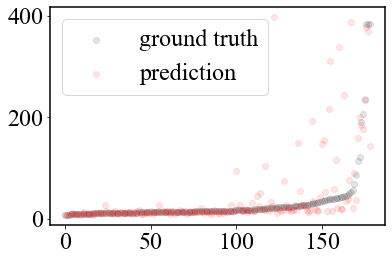

In [144]:
#evaluate
import scipy
net.load_state_dict(torch.load(models[0][1]))
# net.load_state_dict(torch.load("saved_models_imdb/model.pt"))
net.to('cuda')
net.eval()

y_true = []
y_pred = []
y_qid = []
y_pid = []
group_ids = []
def gm(y_true, y_pred):
    e = np.abs(np.array(y_true) - np.array(y_pred))
    return np.prod(e)**(1/len(e))
for i, data in enumerate(test_dataloader, 0):
    plans, times, q_id, p_id, lens, resources, weights, group_id, idx = data
    lens_n_resources1 = torch.hstack((lens.reshape((-1, 1)), resources, group_id.reshape((-1, 1))))
    lens_n_resources_padded1 = lens_n_resources1.reshape((-1, 1, 6))
    lens_n_resources_padded1 = F.pad(lens_n_resources_padded1, (0, plans.shape[-1]-6), 'constant', 0)
    inputs1 = torch.cat((plans, lens_n_resources_padded1), 1)
    labels1 = times.reshape((-1, 1)).to(torch.float32)
    
    if (use_gpu):
        inputs1, labels1 = inputs1.cuda(), labels1.cuda()
    
    outputs = net.forward(inputs1, 0)

    y_true.append(times.cpu().detach().numpy())
    y_pred.append(outputs[0].cpu().detach().numpy())
    # y_qid.append(q_id.cpu().detach().numpy())
    # y_pid.append(p_id.cpu().detach().numpy())

    # print(inputs1)
    # torch.save(inputs1, 'test_input.pt')
    # print(y_pred)
    # break
    
y_pred = np.concatenate(y_pred,axis=0).squeeze()
y_true = np.concatenate(y_true,axis=0).squeeze()
# y_qid = np.concatenate(y_qid,axis=0).squeeze()
# y_pid = np.concatenate(y_pid,axis=0).squeeze()

y_pred = [(i*(time_max - time_min)+time_min)/1000 for i in y_pred]
y_true = [(i*(time_max - time_min)+time_min)/1000 for i in y_true]

print(f'mape: {mape(y_true, y_pred)}')
print(f'mse: {mean_squared_error(y_true, y_pred)}')
print(f'r2: {r2_score(y_true, y_pred)}')
print(f'pearson corr: {scipy.stats.pearsonr(y_true, y_pred)}')

print(f'qerror 50%: {qerror(y_true, y_pred, 0.5)}')
print(f'qerror 90%: {qerror(y_true, y_pred, 0.9)}')
print(f'qerror: {qerror(y_true, y_pred)}')
print(f'gm: {gm(y_true, y_pred)}')

import matplotlib.pyplot as plt

x = range(len(y_true))
zipped = zip(y_true, y_pred)
zipped =list(zipped)
zipped = sorted(zipped, key=lambda x: x[0])
negs = 0.0
for i, j in zipped:
    if (i > j): negs += i-j
print(f'neg: {negs/len(y_true)}')

plt.scatter(x,[i[0] for i in zipped], color="black",alpha=0.1, label='ground truth')
plt.scatter(x,[i[1] for i in zipped], color="red", alpha=0.1, label='prediction')
ax = plt.gca()
# ax.set_yscale('log')
plt.legend()
plt.show

In [145]:
# import pickle
# with open('imdb.pkl', 'wb') as handle:
#     pickle.dump(zipped, handle)

In [146]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import os
import csv

font = {'size' : 24}
matplotlib.rc('font', **font)
matplotlib.rcParams['axes.linewidth'] = 1.5


import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['/home/kaiqi.liu/fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

plt.rcParams["font.family"] = "Times New Roman"
sorted([f.name for f in font_manager.fontManager.ttflist])

plt.figure(dpi=200)

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

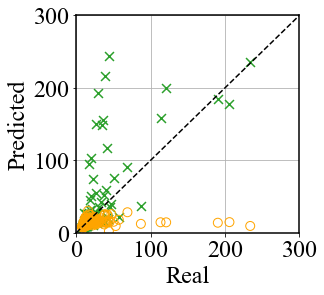

In [147]:
import matplotlib.pyplot as plt
import matplotlib
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid()
line = matplotlib.lines.Line2D([0, 1], [0, 1], color='black', ls='--')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

x = range(len(y_true))
zipped = zip(y_true, y_pred)
zipped =list(zipped)
zipped = sorted(zipped, key=lambda x: x[0])

ax.set_ylim(0,300)
ax.set_xlim(0,300)
ax.set_xticks(range(0,301,100))
ax.set_yticks(range(0,301,100))

# plt.scatter(x,[i[0] for i in zipped], color="black", alpha=0.2, s = 50, label='Ground truth')
plt.scatter([i[0] for i in zipped],[i[1] for i in zipped], color="tab:green", s=80, marker='x', label='Ours')

with open('raal-imdb.pkl', 'rb') as f:
    raal = pickle.load(f)
    plt.scatter([i[0] for i in raal],[i[1] for i in raal], edgecolor="orange", facecolors='none', s=80, marker = 'o', label='RAAL')


ax.set_xlabel("Real")
ax.set_ylabel("Predicted")
# plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.gcf().set_size_inches(4,4)


In [148]:

tail30 = zipped[int(0.7*len(zipped)):]
negs = 0.0
for i, j in tail30:
    if (i > j): negs += i-j
y_true, y_pred = zip(*tail30)
print('\ntail30')
print(f'mape: {mape(y_true, y_pred)}')
print(f'mse: {mean_squared_error(y_true, y_pred)}')
print(f'qerror: {qerror(y_true, y_pred)}')
# print(f'r2: {r2_score(y_true, y_pred)}')
print(f'pearson corr: {scipy.stats.pearsonr(y_true, y_pred)}')
# print(f'qerror 50%: {qerror(y_true, y_pred, 0.5)}')
# print(f'qerror 90%: {qerror(y_true, y_pred, 0.9)}')
# print(f'gm: {gm(y_true, y_pred)}')
print(f'neg: {negs/len(y_true)}')

tail20 = zipped[int(0.8*len(zipped)):]
negs = 0.0
for (i, j) in tail20:
    if (i > j): negs += i-j
y_true, y_pred = zip(*tail20)
print('\ntail20')
print(f'mape: {mape(y_true, y_pred)}')
print(f'mse: {mean_squared_error(y_true, y_pred)}')
print(f'qerror: {qerror(y_true, y_pred)}')
# print(f'r2: {r2_score(y_true, y_pred)}')
print(f'pearson corr: {scipy.stats.pearsonr(y_true, y_pred)}')
# print(f'qerror 50%: {qerror(y_true, y_pred, 0.5)}')
# print(f'qerror 90%: {qerror(y_true, y_pred, 0.9)}')
# print(f'gm: {gm(y_true, y_pred)}')
print(f'neg rate: {negs/len(y_true)}')



tail30
mape: 1.2112788268866836
mse: 9270.06272205754
qerror: 2.3938226395471807
pearson corr: (0.5721217270600051, 6.195749729259985e-06)
neg: 11.917441097864673

tail20
mape: 1.5014589399476883
mse: 13366.843634253515
qerror: 2.731259130037037
pearson corr: (0.5119507364272566, 0.001414413695715045)
neg rate: 15.76353042448436


In [149]:
res = [i for i in zip(group_ids, y_qid, y_pid, y_true, y_pred)]
res.sort()
res

[]

In [150]:
val_ids = list(set([(i[0], i[1]) for i in res]))
val_ids.sort()
print(len(val_ids))
top1 = 0
top3 = 0
top5 = 0
percent_1 = 0
percent_5 = 0
for q in val_ids[:]:
    queries = [i for i in res if((i[0], i[1]) == q)]
    queries.sort(key=lambda y: y[3])
    gt = queries[0][3]
    gt_idx = queries[0][2]
    queries.sort(key=lambda y: y[4])
    idxs = [i[2] for i in queries]
    predicts = [i[3] for i in queries]
    if(gt_idx == idxs[0]):
        top1 += 1
        top3 += 1
        top5 += 1
    elif(gt_idx in idxs[:3]):
        top3 += 1
        top5 += 1
    elif(gt_idx in idxs[:5]):
        top5 += 1
    if((predicts[0] - gt)/gt <= 0.01):
        percent_5 += 1
        percent_1 += 1
    elif((predicts[0] - gt)/gt <= 0.05):
        percent_5 += 1
print(top1, top3, top5)
print(percent_1, percent_5)

0
0 0 0
0 0


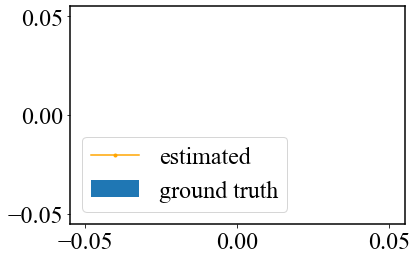

In [151]:
data = [i for i in res if i[0] == 0 and i[1] == 5]
x = [i[2] for i in data]
y1 = [i[3] for i in data]
y2 = [i[4] for i in data]
plt.bar(x, y1, label = "ground truth")
plt.plot(x, y2, color='orange', marker = '.', label="estimated")
plt.legend(loc="lower left")
plt.show()

In [152]:
## save model for deployment
net.eval().cpu()
# torch.save(net.state_dict(), "ce_lstm.pt")
x = torch.rand(36,237)
traced_cell = torch.jit.trace(net, (x))
traced_cell.save('./test_model.zip')

IndexError: too many indices for tensor of dimension 2

In [ ]:
n_candidates = 128
step = 1
if n_candidates > 500:
        step = 8
elif n_candidates > 200:
        step = 4
elif n_candidates > 100:
        step = 2
ranges = range(0, n_candidates, step)
candidates = []
for i in range(0, n_candidates - step + 1, step):
    candidates.append(random.randint(i, i + step - 1))
print(candidates)
print(len(candidates))

[0, 3, 5, 6, 9, 11, 12, 15, 16, 19, 20, 23, 24, 26, 28, 30, 33, 34, 37, 38, 41, 43, 44, 46, 48, 50, 52, 54, 56, 58, 60, 63, 64, 66, 68, 71, 73, 74, 77, 78, 80, 83, 85, 87, 88, 91, 92, 95, 96, 99, 101, 102, 105, 107, 108, 111, 112, 115, 116, 118, 120, 122, 125, 126]
64


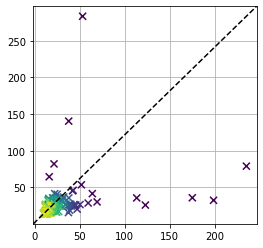

In [ ]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde
import numpy as np

with open('raal-imdb.pkl', 'rb') as f:
    raal = pickle.load(f)
    x = [i[0] for i in raal]
    y = [i[1] for i in raal]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)


    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50, marker='x')
ax.set_axisbelow(True)
ax.grid()
line = matplotlib.lines.Line2D([0, 1], [0, 1], color='black', ls='--')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.gcf().set_size_inches(4,4)
plt.show()

